# Analysis of Spread of PDAF Protest Sentiment on Twitter

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json
import glob
import ast

import networkx as nx
from itertools import combinations
from collections import Counter 

In [2]:
# load data paths
paths = glob.glob("data/*")
paths

['data/new_tweets_mpm.json',
 'data/tweets_mpm_list_following.json',
 'data/user_followers.json',
 'data/user_following.json']

In [3]:
## IMPLEMENT KEY DUPLICATE REMOVER DURING CLEANING?
## Dictionaries automatically remove duplicates

In [4]:
def read_dict_from_file(path):

    # open scraped file as string
    f = open(path).read()

    # convert scraped file from string to dictionary
    dic = ast.literal_eval(f)

    # return dictionary of file
    return dic

In [5]:
def clean_dict(dirty_dict, name_type="full_name"):

    # define new dictionary
    new_dict = {}

    # get keys from input dirty dict
    keys = dirty_dict.keys()

    for key in keys:

        # format is [{"full_name" : "XX", "screen_name" : "YY"}]
        value = dirty_dict[key]

        # get followers full_name per user
        full_names = [d["full_name"] for d in value]

        # get followers screen name per user
        screen_names = [d["screen_name"] for d in value]

        # make key: value pair using full_name per user
        new_dict[key] = full_names

    # return new_dict
    return new_dict

# Analysis

## Preparing Follower and Following Data

In [36]:
# load dirty followers dictionary
path = "data/user_followers.json"
dirty_followers = read_dict_from_file(path)

# get clean followers, full_name
clean_followers = clean_dict(dirty_followers, "full_name")

# load dirty following dictionary
path = "data/user_following.json"
dirty_following = read_dict_from_file(path)

# get clean following, full_name
clean_following = clean_dict(dirty_following, "full_name")

In [7]:
# function to combine (get union) dictionaries
def union_dict(a, b):
    # a is the bigger dataset we will update with b
    for k, v in a.items():
        # if key is in a and b, then just append to current data in a
        if k in b.keys():
            # get union of unique items (remove redundancy)
            a[k] = list(set(a[k] + b[k]))

    # append keys in b that are not in a
    for k, v in b.items():
        if k not in a.keys():
            a[k] = v

    return a

In [8]:
# Test
a = {"a":[1, 2, 5], "b":[2, 3, 4]}
b = {"a":[1, 2, 3, 4], "c":[8, 9]}
union_dict(a, b)

{'a': [1, 2, 3, 4, 5], 'b': [2, 3, 4], 'c': [8, 9]}

In [9]:
# convert following to followers format
# e.g. {"user_A": ["followed_user_1", "followed_user_2"]
# turn to: {"followed_user_1" : ["user_A], "followed_user_2": ["user_A"]}
# So network direction goes from user (followed) to follower

def swap_key_val(old_dic):

    # get keys of dictionary to swap
    keys = old_dic.keys()

    # convert keys to vals and vals to keys
    # initiate new dictioanary (swapped)
    new_dic = {}
    for key in keys:
        # swap value and key
        a = {val: [key] for val in old_dic[key]}
        # add to new_dic using union_dict function
        new_dic = union_dict(new_dic, a)
    return new_dic

In [21]:
# Test
a = {"follower_a":["a", "b"], "follower_b":["b", "c", "d"]}
b = swap_key_val(a)
b

{'a': ['follower_a'],
 'b': ['follower_a', 'follower_b'],
 'c': ['follower_b'],
 'd': ['follower_b']}

In [37]:
a = clean_followers.copy()
b = clean_following.copy()

# get followers data from following data
followers_from_following = swap_key_val(b)

# get union of followers data (scraped) and followers from following data
unified_followers = union_dict(a, followers_from_following)

In [39]:
# save unified_followers to json
with open('data/unified_followers.json', 'w') as f:
    json.dump(unified_followers, f)

In [ ]:
# load saved file


In [40]:
# get unified following data
# get following data from followers data

a = clean_followers.copy()
b = clean_following.copy()

following_from_followers = swap_key_val(a)

# get union of followers data (scraped) and followers from following data
unified_following = union_dict(b, following_from_followers)

In [41]:
# load saved file

(3028, 2757)

In [42]:
# save unified_following to json
with open('data/unified_following.json', 'w') as f:
    json.dump(unified_following, f)

In [43]:
# length of scraped following
len(clean_following)

2757

In [44]:
# length of unified following
len(unified_following)

109200

In [45]:
# num of all users:followers scraped
len(unified_followers.keys())

78798

In [46]:
# num in just clean_followers
len(clean_followers.keys())

3028

In [47]:
# num in user:followers from following data
len(followers_from_following.keys())

75783

## Making Followers Graph - Asymmetric

We generate a graph of all the nodes in the followers and following dataset.

In [48]:
# load Graph of followers
G = nx.from_dict_of_lists(unified_followers, create_using=nx.DiGraph())

### Basic Properties

In [49]:
# degrees
degs = [k for n, k in G.degree]
avg_deg = np.mean(degs)
min_deg = np.min(degs)
max_deg = np.max(degs)

vals = {"avg_degree":[avg_deg], "min_degree":[min_deg], "max_degree":[max_deg]}
pd.DataFrame.from_dict(vals).T

0
avg_degree     2.934551
min_degree     0.000000
max_degree  3283.000000

In [50]:
# clustering

### Degree Distribution

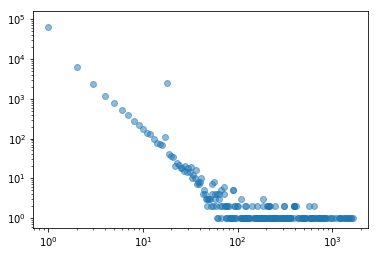

In [51]:
# out degree distribution
degs = [v for k, v in G.out_degree]

# count
deg_count = Counter(degs)

# plot
plt.loglog(deg_count.keys(), deg_count.values(), 'o', alpha=0.5)

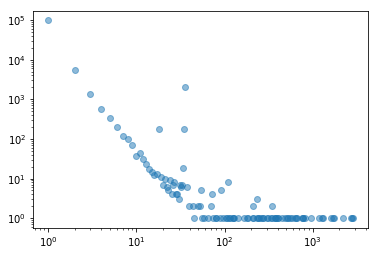

In [52]:
# in degree distribution
degs = [v for k, v in G.in_degree]

# count
deg_count = Counter(degs)

# plot
plt.loglog(deg_count.keys(), deg_count.values(), 'o', alpha=0.5)

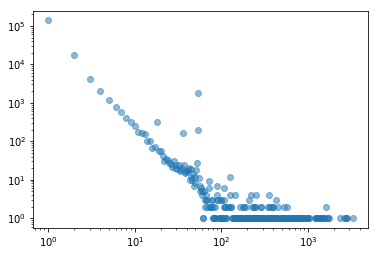

In [53]:
# degree distribution
degs = [v for k, v in G.degree]

# count
deg_count = Counter(degs)

# plot
plt.loglog(deg_count.keys(), deg_count.values(), 'o', alpha=0.5)

In [54]:
# # Use spring layout
# pos = nx.spring_layout(G)

# # draw graph
# plt.figure(figsize=(10, 10))
# nx.draw(G, pos=pos, node_size=2, with_labels=False)

## Filtering Followers Subgraph - Symmetric

The function below only selects that nodes that mutually follow each other (regardless if they tweeted about the protest or not). a <--> b will be preserved while c --> d will not be.

In [55]:
def filter_symmetric(matrix, nodes):
    # get only symmetric
    matrix_sym = np.multiply(matrix, matrix.T)
    
    # make diagonal = 0
    np.fill_diagonal(matrix_sym, 0)
    
    # get indices with at least one degree in the symmetric network
    nonzero = np.array(np.sum(matrix_sym, axis=0))
    inds = list(np.nonzero(nonzero[0])[0])
    
    # select only rows and columns based on index
    matrix_sym = matrix_sym[inds][:, inds]

    # get nodes corresponding to index of nodes in symm network
    sym_nodes = np.array(nodes)[inds]
    
    return matrix_sym, sym_nodes

In [56]:
# TEST
matrix = np.matrix([[1, 0, 1, 1], [1, 1, 0, 1], [1, 0, 0, 0], [0, 1, 1, 1]])
nodes = ['a', 'b', 'c', 'd']
filter_symmetric(matrix, nodes)

(matrix([[0, 0, 1, 0],
         [0, 0, 0, 1],
         [1, 0, 0, 0],
         [0, 1, 0, 0]]), array(['a', 'b', 'c', 'd'], dtype='<U1'))

In [57]:
# # make adjacency matrix
# matrix = nx.adjacency_matrix(G).todense()

# # get nodes list
# nodes = list(G.nodes)

# # THIS SHOULD BE EQUAL
# matrix.shape, len(nodes)

((171171, 171171), 171171)

In [ ]:
# # CAN WE REMOVE THIS? SINCE THE IMPLEMENTATION BELOW WORKS AND THIS BREAKS
# # THIS KILLS THE KERNEL
# # filter symmetric adjacencty matrix
# sym_matrix, sym_nodes = filter_symmetric(matrix, nodes)

# print("No. of links in asymmetric network:", np.sum(matrix))
# print("Shape of asymmetric network:", matrix.shape)
# print("No. of links in symmetric network:", np.sum(sym_matrix)/2)
# print("Shape of symmetric network:", sym_matrix.shape, len(sym_nodes))

In [58]:
# Filter symmetric given dictionary of followers only
def filter_symmetric_from_dict(dic):
    # get dictionary of followers
    
    # define new dictionary    
    sym_dic = {}
    
    # run through keys and values
    for k, v in dic.items():
        # check if symmetric by looking at key and valu
        for i in v:
            try:
                if k in dic[i]:
                    if k in sym_dic:
                        sym_dic[k] += [i]
                    else:
                        sym_dic[k] = [i]
            except:
                continue
    return sym_dic

In [59]:
a = {'z':['e', 'b'], 'a':['b', 'c', 'd'], 'b':['a', 'z'], 'c':['a'], 'd':['c'], 'e':['z']}
filter_symmetric_from_dict(a)

{'a': ['b', 'c'], 'b': ['a', 'z'], 'c': ['a'], 'e': ['z'], 'z': ['e', 'b']}

In [60]:
# Filter the network for symmetric only 

# list of users in symmetric network
user_list = list(unified_followers.keys())

# filter only users in symmetric network
symm_followers = filter_symmetric_from_dict(unified_followers)

# make graph
H = nx.from_dict_of_lists(symm_followers, create_using=nx.DiGraph())

In [61]:
# Number of nodes in symmetric network
len(H.nodes)

11173

### Basic Properties

In [62]:
degs = [k for n, k in H.degree]
avg_deg = np.mean(degs)
min_deg = np.min(degs)
max_deg = np.max(degs)

vals = {"avg_degree":[avg_deg], "min_degree":[min_deg], "max_degree":[max_deg]}
pd.DataFrame.from_dict(vals).T

0
avg_degree     3.595274
min_degree     2.000000
max_degree  1910.000000

### Degree Distribution

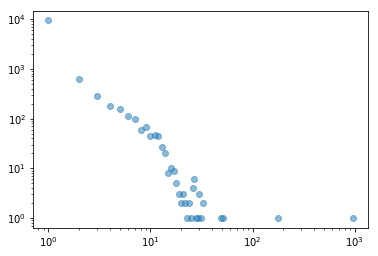

In [63]:
# out degree distribution
degs = [v for k, v in H.out_degree]

# count
deg_count = Counter(degs)

# plot
plt.loglog(deg_count.keys(), deg_count.values(), 'o', alpha=0.5)

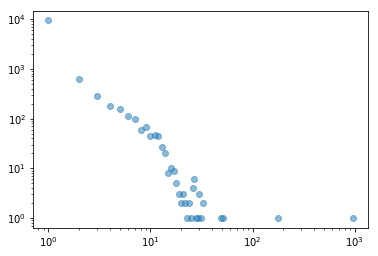

In [64]:
# in degree distribution
degs = [v for k, v in H.in_degree]

# count
deg_count = Counter(degs)

# plot
plt.loglog(deg_count.keys(), deg_count.values(), 'o', alpha=0.5)

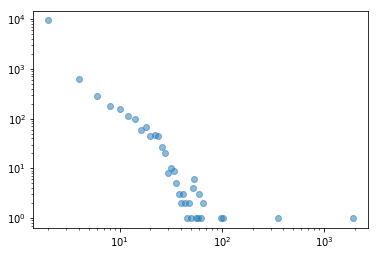

In [65]:
# degree distribution
degs = [v for k, v in H.degree]

# count
deg_count = Counter(degs)

# plot
plt.loglog(deg_count.keys(), deg_count.values(), 'o', alpha=0.5)

In [66]:
# # Use spring layout
# pos = nx.spring_layout(H)

# # draw graph
# plt.figure(figsize=(10, 10))
# nx.draw(H, pos=pos, node_size=2, with_labels=True, font_color='b', font_size=10)

## Fraction of Recruited Users Over Time (Nodes)


In [67]:
# get only nodes (following and followers) that are in a specific list
def filter_users_from_dic(followers_dic, user_list):
    # make dictionary of filtered keys
    filtered_dic = {k: followers_dic[k] for k in user_list}

    # filter values in dictionary - select only those in user_list
    for k, v in filtered_dic.items():
        filtered_dic[k] = [i for i in filtered_dic[k] if i in user_list]

    return filtered_dic

In [ ]:
## CONSIDER RETWEETS - CURRENTLY CODE BELOW REMOVES RETWEETS DUE TO LACK OF DATE

In [68]:
# loading Tweets as dataframe
tweets_0 = pd.read_json("data/new_tweets_mpm.json")

# convert date to date time
tweets = tweets_0.copy()
tweets.date = pd.to_datetime(tweets_0.date)

# remove date outside 2013
tweets = tweets[(tweets['date'] > '2013-01-01 00:00:00')
                & (tweets['date'] < '2013-12-31 00:00:00')]

# sort values by date
tweets = tweets.sort_values(by="date")

# drop duplicates
tweets = tweets.drop_duplicates()

# reset index
tweets = tweets.reset_index()

tweets.head()

index                date  likes  parent_tweet_id  replies  reply  retweet  \
0   9754 2013-08-17 15:45:11      0              NaN        1      0        0   
1   9755 2013-08-17 15:45:37      0     3.687604e+17        0      1        0   
2   9751 2013-08-17 21:33:27      1              NaN        0      0        0   
3   9741 2013-08-18 01:13:49      4              NaN        1      0        0   
4   9742 2013-08-18 01:29:55      0     3.689035e+17        0      1        0   

   retweets                                               text   timestamp  \
0         2  #millionpeoplemarch on august 26 luneta.  This...  1376754311   
1         0                                         @sdoroquis  1376754337   
2         3  Maybe running + bike community wud want 2 know...  1376775207   
3         9  Napoles is just the visible "fall guy" of sort...  1376788429   
4         0  @larionedjames secrets that will soon be revea...  1376789395   

       tweet_id    user_id         user_name user_screen_name  
0  3.687604e+17   32382474             yo de           xuyode  
1  3.687605e+17   32382474             yo de           xuyode  
2  3.688481e+17  470960342      running host     HostBoyramos  
3  3.689035e+17   24533024  Rudy Villar, Jr.       rudyvillar  
4  3.689076e+17   24533024  Rudy Villar, Jr.       rudyvillar

In [69]:
# length of dataframe
len(tweets_0)

9768

In [70]:
# length of tweets only
len(tweets_0[np.logical_and(tweets_0.reply == 0, tweets_0.retweet == 0)])

691

In [71]:
# number of retweets
len(tweets_0[tweets_0.retweet == 1])

7354

In [72]:
# number of replies
len(tweets_0[tweets_0.reply == 1])

1723

Text(0.5,1,'Fraction of recruited users over time')

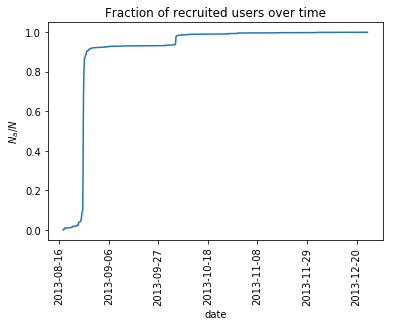

In [73]:
# get only the first time a unique user tweet/retweet or replies with relevant #hash
unique_users = tweets.drop_duplicates(subset="user_name", keep="first")

# sort by date
unique_users = unique_users.sort_values(by="date")

# reset index
unique_users = unique_users.reset_index()

# get cumulative distribution, each user adds 1 to the count
count_cumulative = [i + 1 for i in range(len(unique_users))]
prop_cumulative = [i / len(unique_users) for i in range(len(unique_users))]

# plot the distribution
plt.plot(unique_users.date, prop_cumulative)
plt.xticks(rotation=90)
plt.xlabel("date")
plt.ylabel("$N_a/N$")
plt.title("Fraction of recruited users over time")

In [74]:
## DO THE SAME ABOVE FOR COMBINATIONS OF TWEETS, RETWEETS, and REPLIES

In [75]:
# number of unique users
len(unique_users)

1288

In [76]:
# Add date column to tweets data (without time)
tweets['date'] = [tweets.date[i] for i in range(len(tweets))]

# Number of tweets and unique tweets
print("No. of tweets:", len(tweets))
print("No. of unique tweets:", len(tweets.text.unique()))

# Add date to nodes data for filtering say of degrees?

No. of tweets: 2117
No. of unique tweets: 2081


In [77]:
# filter only those in unified_followers dataset
users_list = list(unified_followers.keys())
tweets_2 = tweets[tweets.user_screen_name.isin(
    users_list)].reset_index(drop=True)
tweets_2 = tweets_2.drop("index", axis=1)
tweets_2.head()

date  likes  parent_tweet_id  replies  reply  retweet  \
0 2013-08-18 01:32:43      0              NaN        1      0        0   
1 2013-08-18 03:36:24      1              NaN        0      0        0   
2 2013-08-18 03:38:49      1              NaN        0      0        0   
3 2013-08-20 11:10:22      2              NaN        0      0        0   
4 2013-08-21 13:23:32      0     3.701717e+17        0      1        0   

   retweets                                               text   timestamp  \
0         5  Let's all go. I'm going. Are you? #porkbarrels...  1376789563   
1         5  The FB event page for #MillionPeopleMarch to L...  1376796984   
2         5  Hashtags for Aug. 26 march - #OnePinoy #Millio...  1376797129   
3         5  yes ! This will happen! RT @barnabychuck: Awes...  1376997022   
4         0  @lynnpinugu @iamsuperbianca lumipas n po. T'wa...  1377091412   

       tweet_id     user_id      user_name user_screen_name  
0  3.689083e+17    56945013          Angku         angkulet  
1  3.689394e+17    74743293  Jane Uymatiao   philippinebeat  
2  3.689400e+17    74743293  Jane Uymatiao   philippinebeat  
3  3.697784e+17     3840981  Noemi L. Dado       momblogger  
4  3.701743e+17  1678345470         Boknoy         PDAFscam

In [78]:
# check for similar tweet_id values
for i in range(len(tweets)):
    if len(tweets[tweets.tweet_id == tweets.tweet_id.values[i]]) > 1:
        display(tweets[tweets.tweet_id == tweets.tweet_id.values[i]])

index                date  likes  parent_tweet_id  replies  reply  \
1464   3153 2013-08-26 08:39:17     92     3.718794e+17        3      1   
1465   2249 2013-08-26 08:39:17     92              NaN        3      0   

      retweet  retweets                                               text  \
1464        0        41  “@mikegam40: Singer, Actor, Composer @keancipr...   
1465        0        41  “@mikegam40: Singer, Actor, Composer @keancipr...   

       timestamp      tweet_id   user_id      user_name user_screen_name  
1464  1377506357  3.719147e+17  30194318  kean cipriano     keancipriano  
1465  1377506357  3.719147e+17  30194318  kean cipriano     keancipriano

index                date  likes  parent_tweet_id  replies  reply  \
1464   3153 2013-08-26 08:39:17     92     3.718794e+17        3      1   
1465   2249 2013-08-26 08:39:17     92              NaN        3      0   

      retweet  retweets                                               text  \
1464        0        41  “@mikegam40: Singer, Actor, Composer @keancipr...   
1465        0        41  “@mikegam40: Singer, Actor, Composer @keancipr...   

       timestamp      tweet_id   user_id      user_name user_screen_name  
1464  1377506357  3.719147e+17  30194318  kean cipriano     keancipriano  
1465  1377506357  3.719147e+17  30194318  kean cipriano     keancipriano

In [79]:
# No. of filtered tweets and users
len(tweets_2), len(tweets_2.user_screen_name.unique())

(1297, 639)

## Filtering Only Users that Tweeted the #Hashtag and their Followers (who may or may not have tweeted the #Hashtag)

### Asymmetric Graph

In [103]:
# get list of unique user_screen_name in pandas dataframe
# this is the list that is both in the followers list and in the tweets data
# No yet concern for TIME so WE USE tweets_0
final_users = list(tweets_0.user_screen_name.unique())
len(final_users)

6463

In [106]:
# filter user - follower dictionary to include only those selected above
# users_followers = {k: unified_followers[k] for k in final_users}

# some users in the dataframe has not been scraped yet
users_followers = {}
for k in final_users:
    try: users_followers[k] = unified_followers[k]
    except: continue

# these are the keys only
len(users_followers)

3038

In [229]:
# make a network using the filtered users_followers above
# load Graph of followers
G = nx.from_dict_of_lists(users_followers, create_using=nx.DiGraph())

# Use spring layout
# pos = nx.spring_layout(G)

len(G.nodes)

109481

#### Basic Properties

In [212]:
degs = [k for n, k in G.degree]
avg_deg = np.mean(degs)
min_deg = np.min(degs)
max_deg = np.max(degs)

vals = {"avg_degree":[avg_deg], "min_degree":[min_deg], "max_degree":[max_deg]}
pd.DataFrame.from_dict(vals).T

0
avg_degree     2.270695
min_degree     0.000000
max_degree  1635.000000

#### Degree Distribution

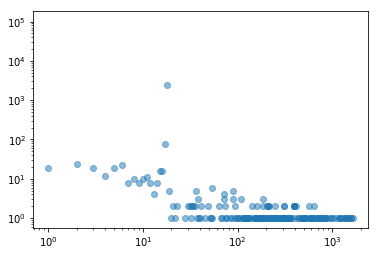

In [124]:
# out degree distribution
degs = [v for k, v in G.out_degree]

# count
deg_count = Counter(degs)

# plot
plt.loglog(deg_count.keys(), deg_count.values(), 'o', alpha=0.5)

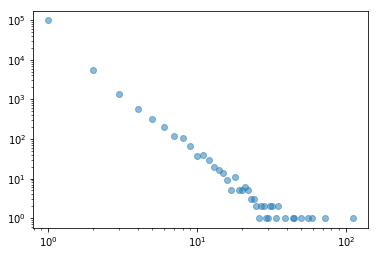

In [125]:
# in degree distribution
degs = [v for k, v in G.in_degree]

# count
deg_count = Counter(degs)

# plot
plt.loglog(deg_count.keys(), deg_count.values(), 'o', alpha=0.5)

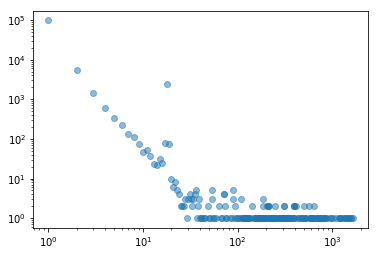

In [110]:
# degree distribution
degs = [v for k, v in G.degree]

# count
deg_count = Counter(degs)

# plot
plt.loglog(deg_count.keys(), deg_count.values(), 'o', alpha=0.5)

In [126]:
# # Use spring layout
# pos = nx.spring_layout(G)

# # draw graph
# plt.figure(figsize=(8, 8))
# nx.draw(G, pos=pos, node_size=2, with_labels=True)

### Symmetric Graph

In [127]:
# filter only symmetric
sym_users_followers = filter_symmetric_from_dict(users_followers)
len(sym_users_followers)

12

In [128]:
# load Graph of followers
H = nx.from_dict_of_lists(sym_users_followers)


#### Degree Distribution

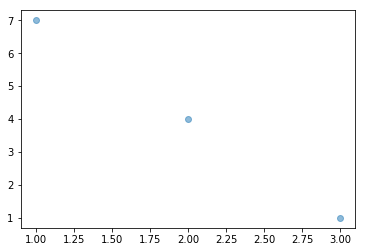

In [129]:
# degree distribution
degs = [v for k, v in H.degree]

# count
deg_count = Counter(degs)

# plot
plt.plot(deg_count.keys(), deg_count.values(), 'o', alpha=0.5)

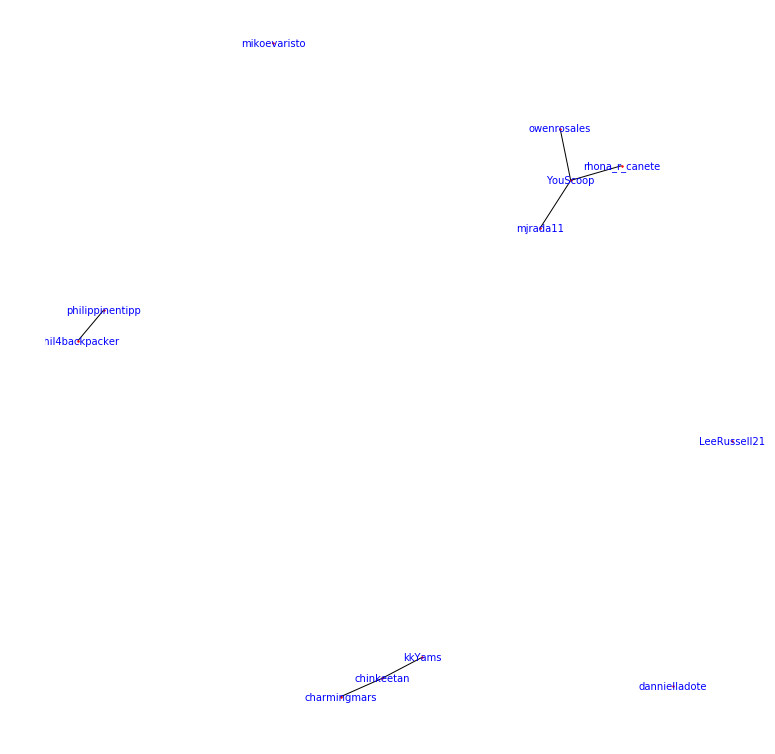

In [130]:
# Use spring layout
pos = nx.spring_layout(H)

# draw graph
plt.figure(figsize=(10, 10))

# draw graph
nx.draw(H, pos=pos, node_size=2, with_labels=True,
        font_color='b', font_size=10)

## Recruitment Thresholds Distribution

### Overall Threshold Distribution - Asymmetric

In [131]:
## WE DON'T HAVE DATE FOR RETWEETS. HOW CAN WE SOLVE THIS

In [142]:
def get_thresholds(following_counts, unique_users):
    # input is a dictionary of {users : num of following}
    # input is unique users to select
    
    # initiate threshold dict
    thresh_dic = {}

    # Count the number of friends who activated at the time of activation, ka
    for user in list(following_counts.keys()):
        
        # check if user in user_name in the dataset otherwise continue
        if user not in unique_users.user_name.values:
            continue
        
        date_activated = unique_users[unique_users.user_name == user].date

        # filter users whose date < date activated
        preactivated_users = unique_users[unique_users.date.values <
                                          date_activated.values]

        # filter only those being followed by user
        _ = preactivated_users[preactivated_users.user_name.isin(
            unified_following[user])]

        # get number of preactivated users that are being followed
        ka = len(_)

        # get number of people followed
        k = following_counts[user]

        # get threshold
        thresh = ka / k

        # append to dictionary
        thresh_dic[user] = thresh

    return thresh_dic

In [211]:
# get following counts
following_counts = {k: len(v) for k, v in unified_following.items()}

# unique_users are unfiltered. Symmetric
unique_users = tweets.drop_duplicates(subset="user_name", keep="first")

# show some threshold values
thresholds = get_thresholds(following_counts, unique_users)

# display
len(thresholds)

283

In [156]:
# mean threshold
np.mean([v for k, v in thresholds.items()])

0.0025057180534212337

Text(0.5,1,'Num nodes vs ka/k')

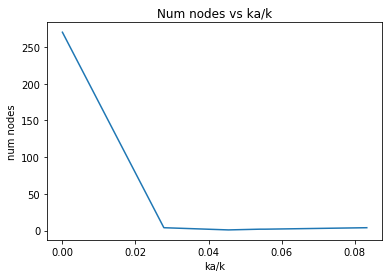

In [153]:
# plot distribution proportion of nodes vs ka/k
thresh = [v for k, v in thresholds.items()]
thresh_counts = Counter(thresh)
x = np.array(list(thresh_counts.keys()))
inds = np.argsort(x)
x = x[inds]
y = np.array(list(thresh_counts.values()))[inds]
plt.plot(x, y)
plt.xlabel("ka/k")
plt.ylabel("num nodes")
plt.title("Num nodes vs ka/k")

### Overall Threshold Distribution - Symmetric

In [160]:
# Filter the network for symmetric only
# list of users and who they follow in symmetric network
symm_following = filter_symmetric_from_dict(unified_following)

# make graph
H = nx.from_dict_of_lists(symm_following, create_using=nx.DiGraph())

len(H.nodes)

11173

In [210]:
# get following counts
following_counts = {k: len(v) for k, v in symm_following.items()}

# unique_users are unfiltered. Symmetric
unique_users = unique_users

# show some threshold values
thresholds = get_thresholds(following_counts, unique_users)

len(thresholds)

84

In [164]:
# mean threshold
np.mean([v for k, v in thresholds.items()])

0.023242630385487528

Text(0.5,1,'Num nodes vs ka/k')

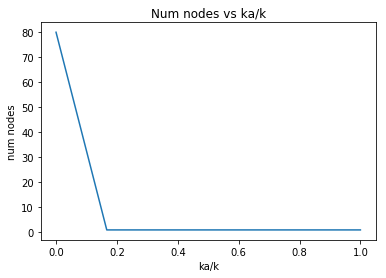

In [165]:
# plot distribution proportion of nodes vs ka/k
thresh = [v for k, v in thresholds.items()]
thresh_counts = Counter(thresh)
x = np.array(list(thresh_counts.keys()))
inds = np.argsort(x)
x = x[inds]
y = np.array(list(thresh_counts.values()))[inds]
plt.plot(x, y)
plt.xlabel("ka/k")
plt.ylabel("num nodes")
plt.title("Num nodes vs ka/k")

### Distribution Before and After Protest

## Recruitment Bursts

## Recruitment Activation Over Time

## Distribution of Cascade Size

In [ ]:
# How to identify cascade? retweet of same message?
    # Count how many retweeted same message = cascade size?
    # Count how many used the same #hashtag - cascade size?
    # Add k core attributes per node
    # Find K core of who started = seed/leader
    # Associate cascade size with k core of seed/leader

In [191]:
# count retweets for each parent id
cascade_sizes = tweets_0.groupby(
    by="parent_tweet_id").count().reset_index().iloc[:, :2].date.values
# we add the original tweet
cascade_sizes = cascade_sizes + 1

Text(0.5,1,'Distribution of cascade size')

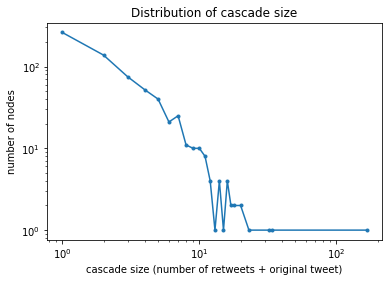

In [209]:
x = np.array(list(Counter(cascade_sizes).keys()))
inds = np.argsort(x)
x = x[inds]
y = np.array(list(Counter(cascade_sizes).values()))[inds]
plt.loglog(x, y, marker=".", )
plt.xlabel("cascade size (number of retweets + original tweet)")
plt.ylabel("number of nodes")
plt.title("Distribution of cascade size")

## Node Centrality (K Core) vs Cascade Size

In [227]:
# make a dictionary of parent tweet_id and cascade size
# Check in the asymmetric network and symmetric network
# will associate parent_tweet_id with original tweeter and calculate k core
_ = tweets_0.groupby(
    by="parent_tweet_id").count().reset_index().iloc[:, :2]
# rename column to cascade
_ = _.rename(columns={"date": "cascade"})
_.head()

parent_tweet_id  cascade
0     3.229498e+16        0
1     3.229898e+16        0
2     3.687604e+17        1
3     3.688481e+17        0
4     3.689035e+17        1

In [230]:
# k cores in asymmetric network
# from G above - includes followers who do not follow back and did not tweet
# about the protest
len(G.nodes)

109481

In [244]:
# remove self-loops
G.remove_edges_from(nx.selfloop_edges(G))

In [247]:
# k cores in symmetric network - includes those who did not tweet about the protest
k_cores = nx.k_core(G, k=2)

len(k_cores.nodes)

# SAVE KCORE AS ATTRIBUTE OF NODE

10830

In [ ]:
# k cores of asymmetric network - whose nodes are only those that tweeted about the protest

In [ ]:
# k cores of symm network - whose node are only those that tweeted about the protest